
# Practical Power Balancing for a Local Community


#### Importing the needed packages
The first step in every python notebook is to install the needed packages (e.g. [`pandas`](https://pandas.pydata.org/docs/user_guide/index.html) for data management) as well as functions and classes from external scripts.

In [1]:
from illuminator.engine import Simulation
import functions_T1
import pandas as pd
import nest_asyncio
nest_asyncio.apply()

In this tutorial a neighbourhood is connected to the grid as sketched below. For a typical day in the year the neighbourhood has a given demand profile (load_data.txt file). The given load data is for a year and is given in 15 minute intervals. This electricity demand must be fulfilled.

#### Task 1: Load Profile for a Neighbourhood

In the first task entails the neighbourhood takes all electricity from the grid. The demand of the neighbourhood can be visualized in a load profile for a day of choice. The following python code plots a specified day based on the given load data and the specified number of houses in the neighbourhood. Electricity from the grid comes from various sources. The energy mix of the Netherlands can be found under https://www.iea.org/countries/the-netherlands/energy-mix. In the code the load data is first saved in a pandas dataframe and it is ensured that the index is the time. Then the day is chosen and a function is called to plot the load data on this day. 
<br> <br> Run the code and describe what you can see in the plot (certain regular peaks, irregularities, etc.). You can vary the day for which you want to plot the load with the day_of_year parameter. Here, you can also compare the load on different days.

![T1_basecase](Graphics_T1/neighbourhood_base_case_T1.png)

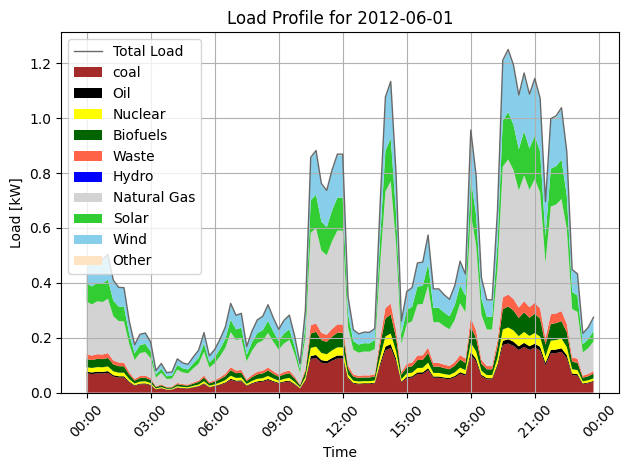

In [2]:
load_df = pd.read_csv('data/load_data.txt', delimiter=',', skiprows=1)
load_df['time'] = pd.to_datetime(load_df['time'])
load_df.set_index('time', inplace=True)
#choose which day of the year to plot
day_of_year = "2012-06-01"
number_houses = 5 
plot_load_base_case = functions_T1.plot_load_profile(load_df, day_of_year, number_houses)

The community implements small scale PV and wind power plants to become more autonomous. Now first the supply from the local renewable energy sources is used to cover the demand in the community. The residual load is then supplied by the grid. In case of excess renewable generation the generated electricity is fed into the grid.

![T1_RES_case](Graphics_T1/neighbourhood_RES_case_T1.png)

#### Task 2: Neighbourhood with local RES

In the below presented code the neighbourhood is set up by defining the key components (here Wind, PV and Load). After defining number of houses and specifications of the installed wind and solar energy in the neighbourhood, a simulation is created and started with the simulation_creator_Balancing class. Finally, the summarise_results function creates a plot and an hourly table with the key results.

Run the following python code and look at the resulting residual load plot. Describe the plot and compare it to the results from task 1. How did the load change for the different days you tested in task 1? Vary the installed PV and Wind power as well as the number of houses in the neighbourhood. Describe your findings.

In [2]:
%%capture
CONFIG_FILE = 'Tutorial_Power_Balance_a.yaml'
simulation_RES = Simulation(CONFIG_FILE)
simulation_RES.set_model_param(model_name='CSVload', parameter='file_path', value='data/load_data.txt')
simulation_RES.set_model_param(model_name='CSV_pv', parameter='file_path', value='data/pv_data_Rotterdam_NL-15min.txt')
simulation_RES.set_model_param(model_name='CSV_wind', parameter='file_path', value='data/winddata_NL.txt')

new_settings = {'Wind1': {'p_rated': 0.3}, # power in kW
                'Load1': {'houses': 5}, # number of houses
                'PV1':{'cap': 500} # installed capacity in W
                }

simulation_RES.edit_models(new_settings)

simulation_RES.set_scenario_param('start_time', '2012-06-01 00:00:00')
simulation_RES.set_scenario_param('end_time', '2012-06-01 23:45:00')

# run the simulation
simulation_RES.run()

2025-02-27 15:15:17.855 | INFO     | mosaik.scenario:start:311 - Starting "Collector" as "Collector-0" ...
2025-02-27 15:15:18.764 | INFO     | mosaik.scenario:start:311 - Starting "CSVload" as "CSVload-0" ...
2025-02-27 15:15:19.293 | INFO     | mosaik.scenario:start:311 - Starting "CSV_pv" as "CSV_pv-0" ...
2025-02-27 15:15:19.790 | INFO     | mosaik.scenario:start:311 - Starting "CSV_wind" as "CSV_wind-0" ...
2025-02-27 15:15:20.279 | INFO     | mosaik.scenario:start:311 - Starting "Load1" as "Load1-0" ...
2025-02-27 15:15:20.281 | INFO     | mosaik.scenario:start:311 - Starting "PV1" as "PV1-0" ...
2025-02-27 15:15:20.282 | INFO     | mosaik.scenario:start:311 - Starting "Wind1" as "Wind1-0" ...
2025-02-27 15:15:20.283 | INFO     | mosaik.scenario:start:311 - Starting "Controller1" as "Controller1-0" ...
2025-02-27 15:15:20.285 | INFO     | mosaik.scenario:run:651 - Starting simulation.
2025-02-27 15:15:20.886 | INFO     | mosaik.scenario:run:708 - Simulation finished successfully.

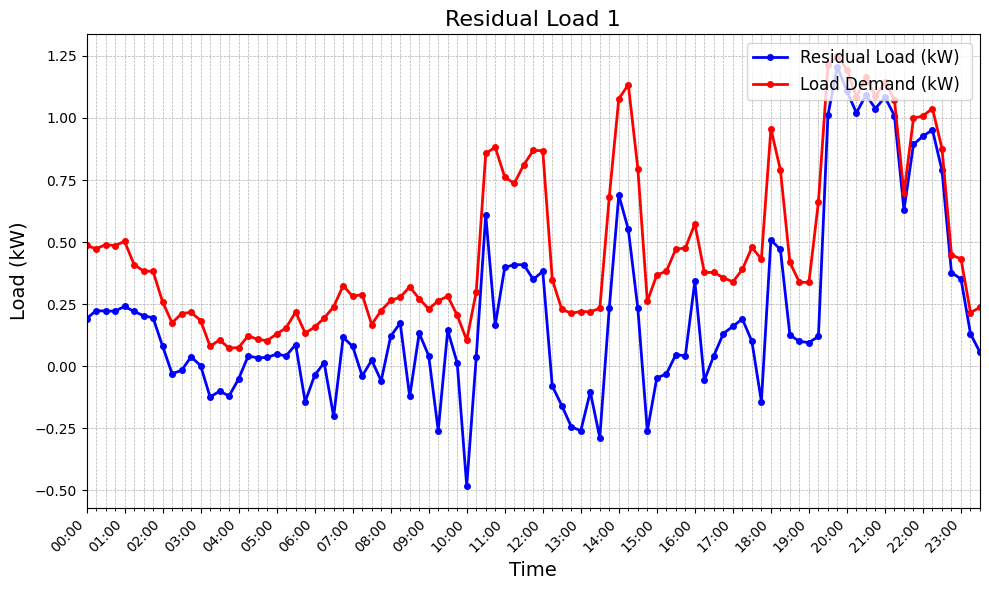

,Date,Time,Load Demand (kW),PV Generation (kW),Wind Generation (kW),Residual Load (kW)
0,2012-06-01,00:00:00,1.94,0,1.08,0.86
1,2012-06-01,01:00:00,1.68,0,0.82,0.86
2,2012-06-01,02:00:00,0.86,0,0.79,0.07
3,2012-06-01,03:00:00,0.44,0,0.78,-0.34
4,2012-06-01,04:00:00,0.41,0,0.35,0.06
5,2012-06-01,05:00:00,0.64,0.21,0.39,0.04
6,2012-06-01,06:00:00,0.92,0.43,0.59,-0.11
7,2012-06-01,07:00:00,0.96,0.72,0.23,0.01
8,2012-06-01,08:00:00,1.14,0.66,0.17,0.31
9,2012-06-01,09:00:00,0.98,0.79,0.25,-0.06


In [3]:
functions_T1.summarize_results('./out_Tutorial_Power_Balance_a.csv', battery_active = False)

The residents have decided to implement a community storage, to enhance the utilization of their local generation. The electricity generated from the local renewable energy sources is stored in the battery when generation exceeds the local demand. The stored energy is used when the local generation cannot cover the demand. 

Thus, the controller connected to the battery acts in the following way: In case of not enough local generation to cover the demand of the neighbourhood electricity is taken from the battery storage if the battery is sufficiently charged. If the battery charge is not enough, electricity is taken from the grid to meet the demand. The storage level of the battery is given by the SOC (State of Charge). The State of Charge of a battery represents the current charge level relative to its full capacity, typically expressed in percentages.  Thus, SOC=100% means the battery is fully charged and SOC=0% means it is fully discharged. To prevent damage the battery has a minimum and maximum SOC (upper and lower boundary) included in the control logic, that cannot be surpassed.

![T1_RES_case_Bat](Graphics_T1/neighbourhood_RES_Bat_case_T1.png)

### Task 3 Neighbourhood with local RES and Communal Battery

a) Run the following python code that simulates a typical day in the local community with renewable generation and battery storage. For this task the State of charge is 100% in the beginning of the day. How does the residual load curve change compared to task 2 (the utilization of small scale local renewable generation without storage).

b) Change the State of charge parameter to 50% in the beginning of the day and run the simulation again. Explain how this affects the residual load curve.

c): Change the State of charge parameter to 10% in the beginning of the day and run the simulation again. Explain how this affects the residual load curve.

In [4]:
%%capture
CONFIG_FILE = 'Tutorial_Power_Balance_b.yaml'
simulation_RES_Bat = Simulation(CONFIG_FILE)
simulation_RES_Bat.set_model_param(model_name='CSVload', parameter='file_path', value='data/load_data.txt')
simulation_RES_Bat.set_model_param(model_name='CSV_pv', parameter='file_path', value='data/pv_data_Rotterdam_NL-15min.txt')
simulation_RES_Bat.set_model_param(model_name='CSV_wind', parameter='file_path', value='data/winddata_NL.txt')

new_settings = {'Wind1': {'p_rated': 0.3}, # power in kW
                'Load1': {'houses': 5}, # number of houses
                'PV1':{'cap': 500}, # installed capacity in W
                'Battery1':{'max_p': 0.8, 'min_p': -0.8,'soc_min': 10, 'soc_max': 90},
                }

simulation_RES_Bat.edit_models(new_settings)

# with this function you can set an initial state of a model such as the soc of the battery
simulation_RES_Bat.set_model_state(model_name='Battery1', state='soc', value=100)

simulation_RES_Bat.set_scenario_param('start_time', '2012-06-01 00:00:00')
simulation_RES_Bat.set_scenario_param('end_time', '2012-06-01 23:45:00')

# run the simulation
simulation_RES_Bat.run()

2025-02-27 15:15:28.535 | INFO     | mosaik.scenario:start:311 - Starting "Collector" as "Collector-0" ...
2025-02-27 15:15:29.484 | INFO     | mosaik.scenario:start:311 - Starting "CSVload" as "CSVload-0" ...
2025-02-27 15:15:29.967 | INFO     | mosaik.scenario:start:311 - Starting "CSV_pv" as "CSV_pv-0" ...
2025-02-27 15:15:30.522 | INFO     | mosaik.scenario:start:311 - Starting "CSV_wind" as "CSV_wind-0" ...
2025-02-27 15:15:30.995 | INFO     | mosaik.scenario:start:311 - Starting "Load1" as "Load1-0" ...
2025-02-27 15:15:30.997 | INFO     | mosaik.scenario:start:311 - Starting "PV1" as "PV1-0" ...
2025-02-27 15:15:30.998 | INFO     | mosaik.scenario:start:311 - Starting "Wind1" as "Wind1-0" ...
2025-02-27 15:15:31.000 | INFO     | mosaik.scenario:start:311 - Starting "Battery1" as "Battery1-0" ...
2025-02-27 15:15:31.000 | INFO     | mosaik.scenario:start:311 - Starting "Controller1" as "Controller1-0" ...
2025-02-27 15:15:31.004 | INFO     | mosaik.scenario:run:651 - Starting sim

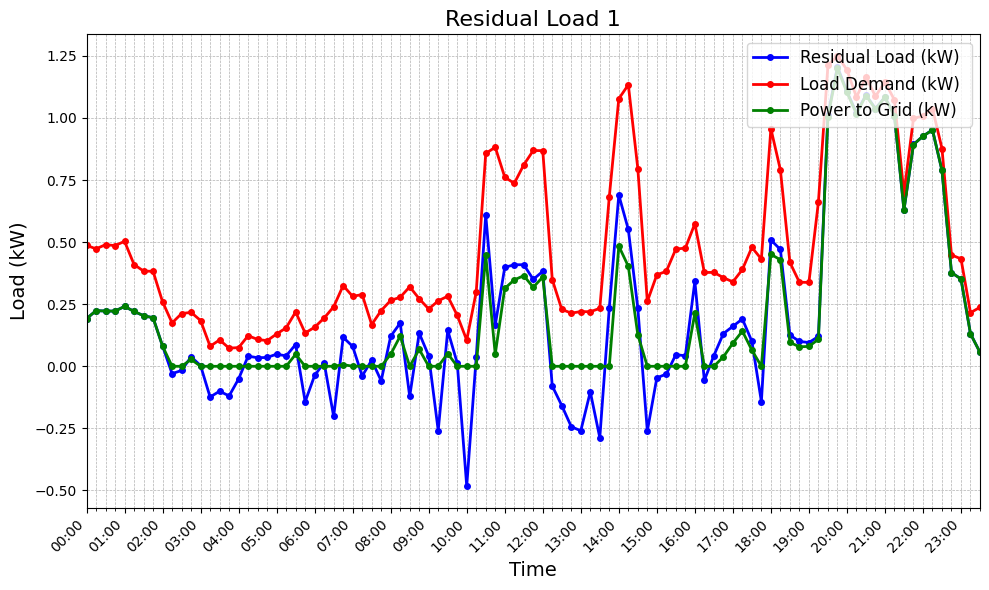

,Date,Time,Load Demand (kW),PV Generation (kW),Wind Generation (kW),Residual Load (kW),Battery SOC (%),Power to Battery (kW),Power to Grid (kW)
0,2012-06-01,00:00:00,1.94,0,1.08,0.86,10,0,-0.86
1,2012-06-01,01:00:00,1.68,0,0.82,0.86,10,0,-0.86
2,2012-06-01,02:00:00,0.86,0,0.79,0.07,10,0.04,-0.11
3,2012-06-01,03:00:00,0.44,0,0.78,-0.34,10.94,0.34,0
4,2012-06-01,04:00:00,0.41,0,0.35,0.06,20.5,-0.06,0
5,2012-06-01,05:00:00,0.64,0.21,0.39,0.04,18.08,0.01,-0.05
6,2012-06-01,06:00:00,0.92,0.43,0.59,-0.11,17.57,0.11,-0.01
7,2012-06-01,07:00:00,0.96,0.72,0.23,0.01,19.95,-0.01,-0
8,2012-06-01,08:00:00,1.14,0.66,0.17,0.31,19.08,-0.07,-0.24
9,2012-06-01,09:00:00,0.98,0.79,0.25,-0.06,15.89,0.11,-0.05


In [5]:
functions_T1.summarize_results('./out_Tutorial_Power_Balance_b.csv', battery_active = True)